# Predicting Educational Outcomes

In [1]:
import re
import requests
import pandas as pd
import numpy as np
import operator
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


from linearmodels import IV2SLS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression


from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso


#Country cleaner corrects any spelling mistakes in the country columns.
from country_cleaner import country_clean


In [2]:
#### Importing csv data files into dataframes df2 and df4 are not used but kept for future analysis.

df = pd.read_csv('Input_Data/education_expenditure_supplementary_data.csv')#Public and private direct expenditures on education institutions as a percentage of gross domestic product
df1 = pd.read_csv('Input_Data/educational_attainment_supplementary_data.csv')#refined list of survey questions by country ########country_name erase this line
df2 = pd.read_csv('Input_Data/school_and_country_table.csv')
df4 = pd.read_csv('Input_Data/timesData.csv')
df_GDP = pd.read_csv('Input_Data/GDP.csv')#Country Name
df_GDP2 = pd.read_csv('Input_Data/GDP.csv')
higherED_df = pd.read_csv('Input_data/cwurData.csv')

### All DFS pass through Country Cleaner.
###Checks to see if there is a country column in the dataframe.  If there is a country column in the dataframe
###the County Cleaner tries to correct spelling mistakes and/or updates the name of the country
country_list = [df, df1, df2, df4, df_GDP, df_GDP2, higherED_df]
country_name_list = ['country','country_name','Country Name', 'Country']



for frame in country_list:
    frame.rename(columns=lambda x: x.strip())
    for col in frame.columns:
        if col in country_name_list:
            frame[col] = frame[col].apply(lambda x: country_clean(x))
            
test_df = df.loc[df['country'] == 'United States of America']
test_df

,country,institute_type,direct_expenditure_type,1995,2000,2005,2009,2010,2011
34,United States of America,All Institutions,Public,5.0,4.6,4.9,5.3,5.1,4.7
71,United States of America,Elementary and Secondary Institutions,Public,3.5,3.5,3.6,3.8,3.7,3.4
108,United States of America,Higher Education Institutions,Public,1.1,0.8,1.0,1.1,1.0,0.9
145,United States of America,All Institutions,Private,NaN,NaN,NaN,NaN,NaN,2.2
182,United States of America,Elementary and Secondary Institutions,Private,NaN,NaN,NaN,NaN,NaN,0.3
219,United States of America,Higher Education Institutions,Private,NaN,NaN,NaN,NaN,NaN,1.8
256,United States of America,All Institutions,Total,NaN,NaN,NaN,NaN,NaN,6.9
293,United States of America,Elementary and Secondary Institutions,Total,NaN,NaN,NaN,NaN,NaN,3.7
330,United States of America,Higher Education Institutions,Total,NaN,NaN,NaN,NaN,NaN,2.7


In [3]:
### Cleaning Higher Ed Data.  We take the top nationally ranked colleges from each country and average the data
rank_one_df = higherED_df[higherED_df['national_rank'] <= 1]


sorted_rank_df = rank_one_df.sort_values(['score','country'],ascending = (False,False))
drop_institution_df = sorted_rank_df.drop(columns=['institution','year'],axis =1)

###Swap columns
first_column = drop_institution_df.pop('country')
drop_institution_df.insert(0, 'country', first_column)

###Get mean and round to remove uncessary zeros.
mean_df = grouped_df = drop_institution_df.groupby(by=['country']).mean().round(2)

h_ed_df= mean_df.copy()

h_ed_df.head()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
country,,,,,,,,,,,
Argentina,372.50,1.0,159.0,488.5,178.0,272.00,349.00,342.00,346.5,804.00,45.52
Australia,91.75,1.0,108.5,139.5,132.5,55.75,102.75,74.25,89.0,67.25,48.04
Austria,214.00,1.0,195.5,172.5,100.5,228.00,150.50,155.50,196.0,704.00,47.40
Belgium,88.00,1.0,361.0,213.5,214.0,44.00,101.50,64.00,52.5,69.00,51.88
Brazil,131.50,1.0,299.5,70.5,214.0,60.50,184.00,125.00,163.0,723.50,49.56


In [4]:
#Cleaning GDP file and averaging out years 2001 through 2011. This will help smooth out missing data and lag between school investments vs results 
df_GDP.rename({'Country Name': 'country'}, axis=1, inplace=True)
df_GDP['avg_2000_2011'] = df_GDP[['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009', '2010','2011']].mean(axis=1)
df_GDP = df_GDP[['country', 'Country Code','Indicator Name', 'Indicator Code','avg_2000_2011']]
df_GDP.dropna(subset=['avg_2000_2011'],inplace=True)
df_GDP.reset_index(inplace=True,drop=True)
df_GDP.head()

,country,Country Code,Indicator Name,Indicator Code,avg_2000_2011
0,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,5.373832e+13
1,High income,HIC,GDP (current US$),NY.GDP.MKTP.CD,3.805390e+13
2,OECD members,OED,GDP (current US$),NY.GDP.MKTP.CD,3.787817e+13
3,Post-demographic dividend,PST,GDP (current US$),NY.GDP.MKTP.CD,3.594110e+13
4,IDA & IBRD total,IBT,GDP (current US$),NY.GDP.MKTP.CD,1.618787e+13


In [5]:
#Cleaning school expenditure file. This file is missing many countries (only has around 30)
#Filtering on school spend and creating dataframe for each by category - e.g. All, k_12, and hihger education
#We may be able to run test on all 3 of these groups 
df['institute_type'] = df['institute_type'].str.strip()
df['direct_expenditure_type'] = df['direct_expenditure_type'].str.strip()

df[['1995','2000','2005','2009','2010','2011']] = df[['1995','2000','2005','2009','2010','2011']]/100
df['school_spend_2000_2011'] = df[['2000','2005','2009', '2010','2011']].mean(axis=1)

df = df[df['direct_expenditure_type']== 'Total']
df = df[['country', 'institute_type','school_spend_2000_2011']]

df_all_edu = df[df['institute_type']=='All Institutions']
df_k_12_edu = df[df['institute_type']=='Elementary and Secondary Institutions']
df_higher_edu = df[df['institute_type']=='Higher Education Institutions']

df_all_edu = df_all_edu.dropna(subset=['school_spend_2000_2011'])
df_k_12_edu = df_k_12_edu.dropna(subset=['school_spend_2000_2011'])
df_higher_edu = df_higher_edu.dropna(subset=['school_spend_2000_2011'])

df_all_edu.reset_index(inplace=True,drop=True)
df_k_12_edu.reset_index(inplace=True,drop=True)
df_higher_edu.reset_index(inplace=True,drop=True)

df_all_edu.head()
df_k_12_edu.head()
df_higher_edu.head()

#df.institute_type.unique()

,country,institute_type,school_spend_2000_2011
0,OECD Average,Higher Education Institutions,0.016
1,Australia,Higher Education Institutions,0.016
2,Austria,Higher Education Institutions,0.015
3,Belgium,Higher Education Institutions,0.014
4,Chile,Higher Education Institutions,0.024


In [6]:
#Merging GDP and expenditure data. The column "school expenditures will be the $$$ spend on schooling"
df_all_edu_1 = df_GDP.merge(df_all_edu, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
df_k_12_edu_1 = df_GDP.merge(df_k_12_edu, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
df_higher_edu_1 = df_GDP.merge(df_higher_edu, on='country', how='left').dropna(subset=['school_spend_2000_2011'])

df_all_edu_1.reset_index(inplace=True,drop=True)
df_k_12_edu_1.reset_index(inplace=True,drop=True)
df_higher_edu_1.reset_index(inplace=True,drop=True)

df_all_edu_1['school_expenditures'] = round(df_all_edu_1['school_spend_2000_2011'] * df_all_edu_1['avg_2000_2011'],2)
df_k_12_edu_1['school_expenditures'] = round(df_k_12_edu_1['school_spend_2000_2011'] * df_k_12_edu_1['avg_2000_2011'],2)
df_higher_edu_1['school_expenditures'] = round(df_higher_edu_1['school_spend_2000_2011'] * df_higher_edu_1['avg_2000_2011'],2)

df_all_edu_1.head()
df_k_12_edu_1.head()
df_higher_edu_1.head()

,country,Country Code,Indicator Name,Indicator Code,avg_2000_2011,institute_type,school_spend_2000_2011,school_expenditures
0,United States of America,USA,GDP (current US$),NY.GDP.MKTP.CD,1.303684e+13,Higher Education Institutions,0.027,3.519947e+11
1,Japan,JPN,GDP (current US$),NY.GDP.MKTP.CD,4.944989e+12,Higher Education Institutions,0.016,7.911982e+10
2,Germany,DEU,GDP (current US$),NY.GDP.MKTP.CD,2.899084e+12,Higher Education Institutions,0.013,3.768809e+10
3,United Kingdom,GBR,GDP (current US$),NY.GDP.MKTP.CD,2.372315e+12,Higher Education Institutions,0.012,2.846777e+10
4,France,FRA,GDP (current US$),NY.GDP.MKTP.CD,2.206148e+12,Higher Education Institutions,0.015,3.309223e+10


In [7]:
### data cleaning the survey file to narrow in on questions we may want to take a look at. Column "series name"
df1 = df1[df1['Keep or not']==1]
df1['avg_2005_2015'] = df1[['2005', '2006','2007','2008','2009','2010','2011','2012','2013','2015']].mean(axis=1)
df1.dropna(subset=['avg_2005_2015'],inplace=True)
df1.reset_index(inplace=True,drop=True)
df1.head()

,country_name,series_name,Keep or not,1985,1986,1987,1990,1991,1992,1993,...,2006,2007,2008,2009,2010,2011,2012,2013,2015,avg_2005_2015
0,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.50,NaN,NaN,0.66,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.97,NaN,NaN,NaN,NaN,1.620
1,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.57,NaN,NaN,1.87,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.85,NaN,NaN,NaN,NaN,3.530
2,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.28,NaN,NaN,0.42,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.16,NaN,NaN,NaN,NaN,1.080
3,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.16,NaN,NaN,1.49,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.23,NaN,NaN,NaN,NaN,2.915
4,Afghanistan,Barro-Lee: Percentage of population age 15+ wi...,1.0,77.80,NaN,NaN,75.04,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,58.38,NaN,NaN,NaN,NaN,62.055


In [8]:
#cleaning GDP file to use again. As many countries are missing expenditures, we can just use toal GDP vs school responses as well. This will be a broader dataset with more countries.
df_GDP2.rename({'Country Name': 'country'}, axis=1, inplace=True)
df_GDP2['avg_2000_2015'] = df_GDP2[['2000','2001','2002','2003','2004','2005','2006','2007','2008','2009', '2010','2011','2012','2013','2014','2015']].mean(axis=1)
df_GDP2['avg_2000_2015'] = df_GDP2['avg_2000_2015']/1000000000
df_GDP2 = df_GDP2[['country', 'Country Code','Indicator Name', 'Indicator Code','avg_2000_2015']]
df_GDP2.dropna(subset=['avg_2000_2015'],inplace=True)
df_GDP2.reset_index(inplace=True,drop=True)
df_GDP2.head()

,country,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,59517.199213
1,High income,HIC,GDP (current US$),NY.GDP.MKTP.CD,40900.271146
2,OECD members,OED,GDP (current US$),NY.GDP.MKTP.CD,40629.787880
3,Post-demographic dividend,PST,GDP (current US$),NY.GDP.MKTP.CD,38437.087014
4,IDA & IBRD total,IBT,GDP (current US$),NY.GDP.MKTP.CD,19195.578598


In [9]:
# joinning survey data_sets with expenditures dataset for final data sets to beging running test on.
df1.rename({'country_name': 'country'}, axis=1, inplace=True)

complete_expenditures_all = df1.merge(df_all_edu_1, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
complete_expenditures_k_12 = df1.merge(df_k_12_edu_1, on='country', how='left').dropna(subset=['school_spend_2000_2011'])
complete_expenditures_higher_edu = df1.merge(df_higher_edu_1, on='country', how='left').dropna(subset=['school_spend_2000_2011'])

In [10]:
#final data-set with total GDP (not expenditures) to run test on as it will have more datapoints vs above compplete tables
complete_GDP = df1.merge(df_GDP2, on='country', how='left').dropna(subset=['avg_2000_2015'])
complete_GDP.head(5)

,country,series_name,Keep or not,1985,1986,1987,1990,1991,1992,1993,...,2010,2011,2012,2013,2015,avg_2005_2015,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.50,NaN,NaN,0.66,NaN,NaN,NaN,...,1.97,NaN,NaN,NaN,NaN,1.620,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
1,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.57,NaN,NaN,1.87,NaN,NaN,NaN,...,3.85,NaN,NaN,NaN,NaN,3.530,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
2,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.28,NaN,NaN,0.42,NaN,NaN,NaN,...,1.16,NaN,NaN,NaN,NaN,1.080,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
3,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.16,NaN,NaN,1.49,NaN,NaN,NaN,...,3.23,NaN,NaN,NaN,NaN,2.915,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
4,Afghanistan,Barro-Lee: Percentage of population age 15+ wi...,1.0,77.80,NaN,NaN,75.04,NaN,NaN,NaN,...,58.38,NaN,NaN,NaN,NaN,62.055,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438


In [11]:
###Keeping columns specific to data we want to analyze
complete_GDP = complete_GDP[(complete_GDP['series_name']=='Barro-Lee: Average years of total schooling, age 25+, total') |(complete_GDP['series_name']=='Barro-Lee: Average years of total schooling, age 25+, female') | (complete_GDP['series_name']=='Barro-Lee: Percentage of population age 25+ with no education')]
complete_GDP.head()                       

,country,series_name,Keep or not,1985,1986,1987,1990,1991,1992,1993,...,2010,2011,2012,2013,2015,avg_2005_2015,Country Code,Indicator Name,Indicator Code,avg_2000_2015
2,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,0.28,NaN,NaN,0.42,NaN,NaN,NaN,...,1.16,NaN,NaN,NaN,NaN,1.080,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
3,Afghanistan,"Barro-Lee: Average years of total schooling, a...",1.0,1.16,NaN,NaN,1.49,NaN,NaN,NaN,...,3.23,NaN,NaN,NaN,NaN,2.915,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
5,Afghanistan,Barro-Lee: Percentage of population age 25+ wi...,1.0,84.62,NaN,NaN,80.70,NaN,NaN,NaN,...,66.02,NaN,NaN,NaN,NaN,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
8,Albania,"Barro-Lee: Average years of total schooling, a...",1.0,6.13,NaN,NaN,7.29,NaN,NaN,NaN,...,9.57,NaN,NaN,NaN,NaN,9.470,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655
9,Albania,"Barro-Lee: Average years of total schooling, a...",1.0,6.75,NaN,NaN,7.83,NaN,NaN,NaN,...,9.85,NaN,NaN,NaN,NaN,9.770,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655


In [12]:
###Pivoting the above DataFrame for readability 
df_pivot=complete_GDP.pivot(index=['country'], columns='series_name',values=['avg_2005_2015'])
df_pivot.columns = df_pivot.columns.droplevel()
modified_df=df_pivot.rename_axis(None,axis=1)
modified_df=modified_df.reset_index()
modified_df_final = modified_df.merge(df_GDP2, on='country', how='left').dropna(subset=['avg_2000_2015'])
modified_df_final

,country,"Barro-Lee: Average years of total schooling, age 25+, female","Barro-Lee: Average years of total schooling, age 25+, total",Barro-Lee: Percentage of population age 25+ with no education,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,Afghanistan,1.080,2.915,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
1,Albania,9.470,9.770,3.185,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655
2,Algeria,4.835,5.570,31.295,DZA,GDP (current US$),NY.GDP.MKTP.CD,133.920615
3,Argentina,9.345,9.370,1.100,ARG,GDP (current US$),NY.GDP.MKTP.CD,345.568498
4,Armenia,10.795,10.835,0.490,ARM,GDP (current US$),NY.GDP.MKTP.CD,7.306080
...,...,...,...,...,...,...,...,...
138,"Venezuela, RB",7.850,7.655,8.460,VEN,GDP (current US$),NY.GDP.MKTP.CD,245.228688
139,Vietnam,6.500,6.945,7.830,VNM,GDP (current US$),NY.GDP.MKTP.CD,96.776592
140,"Yemen, Rep.",1.065,2.230,73.060,YEM,GDP (current US$),NY.GDP.MKTP.CD,24.405175
141,Zambia,5.605,6.460,19.755,ZMB,GDP (current US$),NY.GDP.MKTP.CD,14.815902


In [13]:
###Renaming Dataframe Columns/features
modified_df_final.rename({'Barro-Lee: Average years of total schooling, age 25+, female': 'female_25_plus','Barro-Lee: Average years of total schooling, age 25+, total': 'All_25_plus','Barro-Lee: Percentage of population age 25+ with no education': 'All_25_plus_no_edu'}, axis=1, inplace=True)
modified_df_final.head()

,country,female_25_plus,All_25_plus,All_25_plus_no_edu,Country Code,Indicator Name,Indicator Code,avg_2000_2015
0,Afghanistan,1.080,2.915,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438
1,Albania,9.470,9.770,3.185,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655
2,Algeria,4.835,5.570,31.295,DZA,GDP (current US$),NY.GDP.MKTP.CD,133.920615
3,Argentina,9.345,9.370,1.100,ARG,GDP (current US$),NY.GDP.MKTP.CD,345.568498
4,Armenia,10.795,10.835,0.490,ARM,GDP (current US$),NY.GDP.MKTP.CD,7.306080


In [14]:
###Dummies created using factorize technique
modified_df_final['country_id'] = pd.factorize(modified_df_final.country)[0]
modified_df_final.head()

,country,female_25_plus,All_25_plus,All_25_plus_no_edu,Country Code,Indicator Name,Indicator Code,avg_2000_2015,country_id
0,Afghanistan,1.080,2.915,68.800,AFG,GDP (current US$),NY.GDP.MKTP.CD,12.328438,0
1,Albania,9.470,9.770,3.185,ALB,GDP (current US$),NY.GDP.MKTP.CD,9.476655,1
2,Algeria,4.835,5.570,31.295,DZA,GDP (current US$),NY.GDP.MKTP.CD,133.920615,2
3,Argentina,9.345,9.370,1.100,ARG,GDP (current US$),NY.GDP.MKTP.CD,345.568498,3
4,Armenia,10.795,10.835,0.490,ARM,GDP (current US$),NY.GDP.MKTP.CD,7.306080,4


In [15]:
X_complete_GDP = modified_df_final[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']]
y_complete_GDP = modified_df_final[['country_id']]
X_complete_GDP

,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015
0,1.080,2.915,68.800,12.328438
1,9.470,9.770,3.185,9.476655
2,4.835,5.570,31.295,133.920615
3,9.345,9.370,1.100,345.568498
4,10.795,10.835,0.490,7.306080
...,...,...,...,...
138,7.850,7.655,8.460,245.228688
139,6.500,6.945,7.830,96.776592
140,1.065,2.230,73.060,24.405175
141,5.605,6.460,19.755,14.815902


# Unsupervised Learning

In [16]:
### Kmeans clustering 
X_complete_GDP_normalized = MinMaxScaler().fit(X_complete_GDP).transform(X_complete_GDP)
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(X_complete_GDP)
kmeans.labels_
modified_df_final['cluster'] = kmeans.fit_predict(X_complete_GDP)
y_kmeans = kmeans.predict(X_complete_GDP)
kmeans.labels_
kmeans.cluster_centers_


array([[7.20852000e+00, 7.58896000e+00, 2.02831600e+01, 9.02871700e+01],
       [1.32750000e+01, 1.32750000e+01, 4.45000000e-01, 1.40743376e+04],
       [9.26300000e+00, 9.48800000e+00, 7.36900000e+00, 2.42373195e+03],
       [9.09200000e+00, 9.54350000e+00, 9.33150000e+00, 1.07619918e+03],
       [8.78000000e+00, 9.16750000e+00, 4.10000000e+00, 4.98019991e+03]])

In [17]:
X_complete_GDP = modified_df_final[['All_25_plus', 'avg_2000_2015']]
y_complete_GDP = modified_df_final[['country_id']]
X_complete_GDP


,All_25_plus,avg_2000_2015
0,2.915,12.328438
1,9.770,9.476655
2,5.570,133.920615
3,9.370,345.568498
4,10.835,7.306080
...,...,...
138,7.655,245.228688
139,6.945,96.776592
140,2.230,24.405175
141,6.460,14.815902


In [18]:
#scale x values to better normalize  
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_complete_GDP)


In [19]:

X_complete_GDP = modified_df_final[['All_25_plus', 'avg_2000_2015']]
y_complete_GDP = modified_df_final[['country_id']]
X_complete_GDP
#scale x values to better normalize  
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X_complete_GDP)
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(scaled_features)
kmeans.inertia_
kmeans.cluster_centers_
kmeans.n_iter_
kmeans.labels_[:5]

array([2, 3, 0, 3, 3])

In [20]:
modified_df_final['cluster'] = kmeans.fit_predict(modified_df_final[['All_25_plus', 'avg_2000_2015']])

In [21]:
df = modified_df_final
df.sort_values('avg_2000_2015',ascending=False)
df_all_edu
df_all_edu_1.head()
df_v1 = df.merge(df_all_edu_1, on = 'country', how='left').dropna(subset=['school_expenditures'])
df_v1['school_expenditures'] = df_v1['school_expenditures']/1000000000
df_v1.head()

,country,female_25_plus,All_25_plus,All_25_plus_no_edu,Country Code_x,Indicator Name_x,Indicator Code_x,avg_2000_2015,country_id,cluster,Country Code_y,Indicator Name_y,Indicator Code_y,avg_2000_2011,institute_type,school_spend_2000_2011,school_expenditures
5,Australia,11.645,11.655,0.920,AUS,GDP (current US$),NY.GDP.MKTP.CD,939.856047,5,3,AUS,GDP (current US$),NY.GDP.MKTP.CD,7.580678e+11,All Institutions,0.058,43.967934
6,Austria,8.775,9.685,1.500,AUT,GDP (current US$),NY.GDP.MKTP.CD,345.472946,6,0,AUT,GDP (current US$),NY.GDP.MKTP.CD,3.220216e+11,All Institutions,0.057,18.355233
10,Belgium,10.495,10.725,4.775,BEL,GDP (current US$),NY.GDP.MKTP.CD,418.403374,10,0,BEL,GDP (current US$),NY.GDP.MKTP.CD,3.899835e+11,All Institutions,0.066,25.738912
23,Chile,9.425,9.560,3.370,CHL,GDP (current US$),NY.GDP.MKTP.CD,169.848452,23,0,CHL,GDP (current US$),NY.GDP.MKTP.CD,1.389673e+11,All Institutions,0.064,8.893909
33,Czech Republic,12.960,13.120,0.125,CZE,GDP (current US$),NY.GDP.MKTP.CD,163.509197,33,0,CZE,GDP (current US$),NY.GDP.MKTP.CD,1.498510e+11,All Institutions,0.050,7.492550


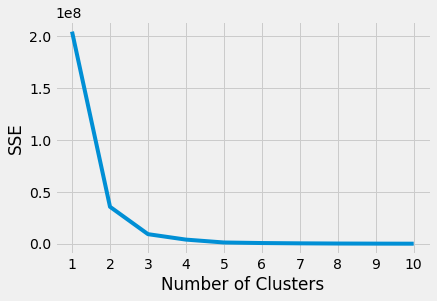

In [22]:
#elbow chart to see number of clusters we should run with 
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df_v1[['avg_2000_2015','school_expenditures']])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

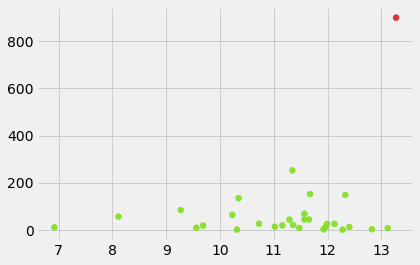

In [23]:
# k means
kmeans = KMeans(n_clusters=2, random_state=0)
df_v1['cluster'] = kmeans.fit_predict(df_v1[['All_25_plus', 'school_expenditures']])# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df_v1['cen_x'] = df_v1.cluster.map({0:cen_x[0], 1:cen_x[1]})
df_v1['cen_y'] = df_v1.cluster.map({0:cen_y[0], 1:cen_y[1]})# define and map colors
colors = ['#81DF20','#DF2020']
df_v1['c'] = df_v1.cluster.map({0:colors[0], 1:colors[1]})

plt.scatter(df_v1.All_25_plus, df_v1.school_expenditures, c=df_v1.c, alpha = 0.9)


Text(0, 0.5, 'GDP')

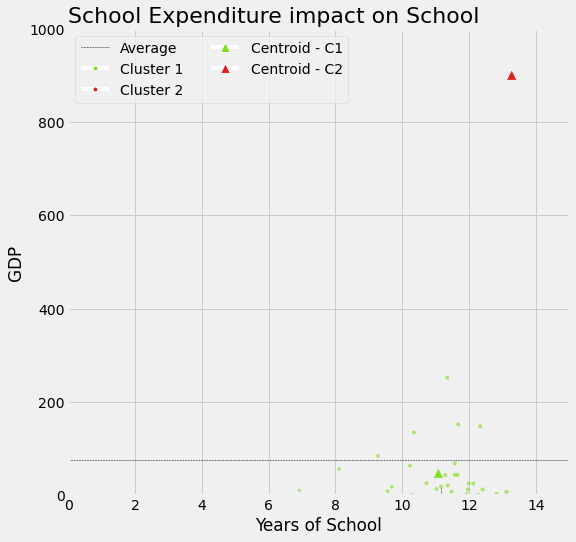

In [24]:
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df_v1.All_25_plus, df_v1.school_expenditures, c=df_v1.c, alpha = 0.6, s=df_v1.All_25_plus)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# plot Attack mean
plt.plot([df_v1.All_25_plus.mean()]*2, [0,15], color='black', lw=0.5, linestyle='--')
plt.xlim(0,15)
# plot Defense mean
plt.plot([0,1000], [df_v1.school_expenditures.mean()]*2, color='black', lw=0.5, linestyle='--')
plt.ylim(0,1000)
# create a list of legend elemntes
## average line
legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
## markers / records
cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
# add all elements to the same list
legend_elements.extend(cluster_leg)
legend_elements.extend(cent_leg)
# plot legend
plt.legend(handles=legend_elements, loc='upper left', ncol=2)# title and labels
plt.title('School Expenditure impact on School', loc='left', fontsize=22)
plt.xlabel('Years of School')
plt.ylabel('GDP')


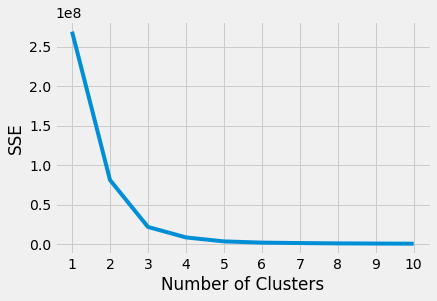

In [25]:
#elbow chart to see number of clusters we should run with 
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(df[['avg_2000_2015','All_25_plus']])
    sse.append(kmeans.inertia_)
    
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [26]:
df_v1.head(100)
df_v1 = df_v1[['cluster','female_25_plus', 'All_25_plus', 'All_25_plus_no_edu', 'cen_x', 'cen_y']]
df_v1.groupby(['cluster']).mean()


,female_25_plus,All_25_plus,All_25_plus_no_edu,cen_x,cen_y
cluster,,,,,
0,10.895,11.080357,2.684643,11.080357,46.613469
1,13.275,13.275000,0.445000,13.275000,899.541961


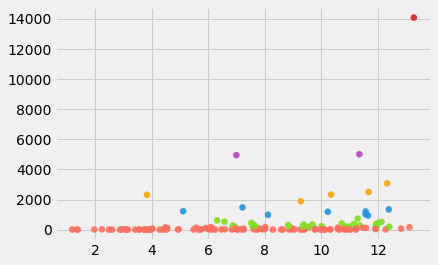

In [27]:
# k means
kmeans = KMeans(n_clusters=6, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['All_25_plus', 'avg_2000_2015']])# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3], 4:cen_x[4], 5:cen_x[5]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3], 4:cen_y[4], 5:cen_y[5]})# define and map colors
colors = ['#81DF20','#DF2020','#FFA500','#2095DF','#BF40BF','#FF6F61']
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2], 3:colors[3] ,4:colors[4],5:colors[5]})

plt.scatter(df.All_25_plus, df.avg_2000_2015, c=df.c, alpha = 0.9)


Text(0, 0.5, 'GDP')

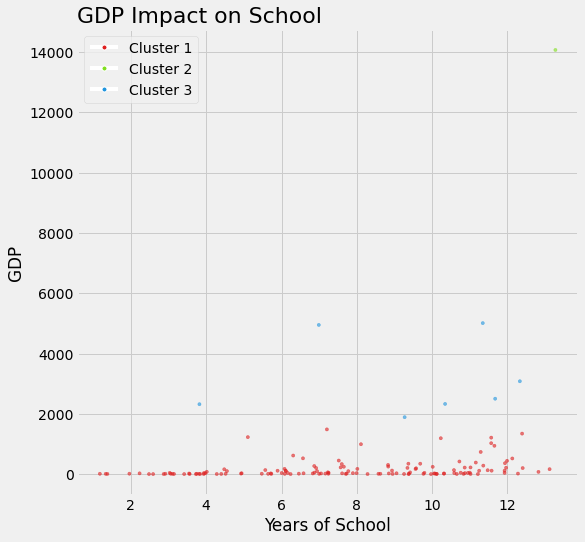

In [28]:
### BUILD A TWO DIMENSIONS CLUSTER AGAIN ###
# k means
kmeans = KMeans(n_clusters=3, random_state=0)
df['cluster'] = kmeans.fit_predict(df[['All_25_plus', 'avg_2000_2015']])# get centroids
centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]
## add to df
df['cen_x'] = df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2]})
df['cen_y'] = df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2]})# define and map colors
colors = ['#DF2020', '#81DF20', '#2095DF']
df['c'] = df.cluster.map({0:colors[0], 1:colors[1], 2:colors[2]})#####PLOT#####
from matplotlib.lines import Line2D
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df.All_25_plus, df.avg_2000_2015, c=df.c, alpha = 0.6, s=10)# create a list of legend elemntes
## markers / records
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]# plot legend
plt.legend(handles=legend_elements, loc='upper left')# title and labels
plt.title('GDP Impact on School', loc='left', fontsize=22)
plt.xlabel('Years of School')
plt.ylabel('GDP')


Text(0, 0.5, 'GDP')

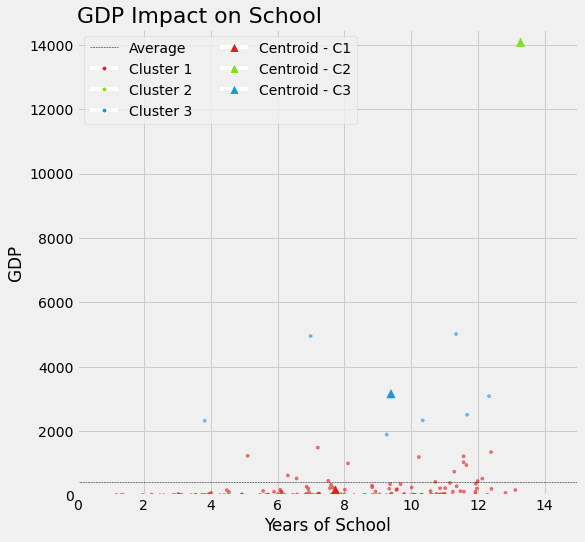

In [29]:
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df.All_25_plus, df.avg_2000_2015, c=df.c, alpha = 0.6, s=10)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# plot Attack mean
plt.plot([df.All_25_plus.mean()]*2, [0,15], color='black', lw=0.5, linestyle='--')
plt.xlim(0,15)
# plot Defense mean
plt.plot([0,14500], [df.avg_2000_2015.mean()]*2, color='black', lw=0.5, linestyle='--')
plt.ylim(0,14500)
# create a list of legend elemntes
## average line
legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
## markers / records
cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
# add all elements to the same list
legend_elements.extend(cluster_leg)
legend_elements.extend(cent_leg)
# plot legend
plt.legend(handles=legend_elements, loc='upper left', ncol=2)# title and labels
plt.title('GDP Impact on School', loc='left', fontsize=22)
plt.xlabel('Years of School')
plt.ylabel('GDP')


Text(0, 0.5, 'GDP')

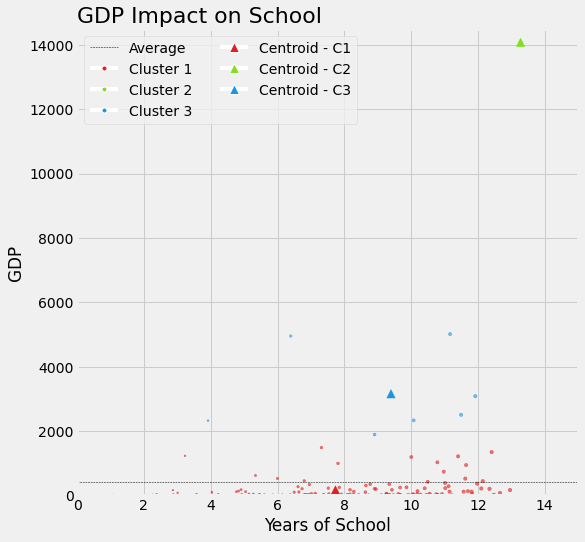

In [30]:
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df.female_25_plus, df.avg_2000_2015, c=df.c, alpha = 0.6, s=df.female_25_plus)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)

# plot Attack mean
plt.plot([df.All_25_plus.mean()]*2, [0,15], color='black', lw=0.5, linestyle='--')
plt.xlim(0,15)
# plot Defense mean
plt.plot([0,14500], [df.avg_2000_2015.mean()]*2, color='black', lw=0.5, linestyle='--')
plt.ylim(0,14500)
# create a list of legend elemntes
## average line
legend_elements = [Line2D([0], [0], color='black', lw=0.5, linestyle='--', label='Average')]
## markers / records
cluster_leg = [Line2D([0], [0], marker='o', color='w', label='Cluster {}'.format(i+1), 
               markerfacecolor=mcolor, markersize=5) for i, mcolor in enumerate(colors)]
## centroids
cent_leg = [Line2D([0], [0], marker='^', color='w', label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in enumerate(colors)]
# add all elements to the same list
legend_elements.extend(cluster_leg)
legend_elements.extend(cent_leg)
# plot legend
plt.legend(handles=legend_elements, loc='upper left', ncol=2)# title and labels
plt.title('GDP Impact on School', loc='left', fontsize=22)
plt.xlabel('Years of School')
plt.ylabel('GDP')


Text(0, 0.5, 'GDP')

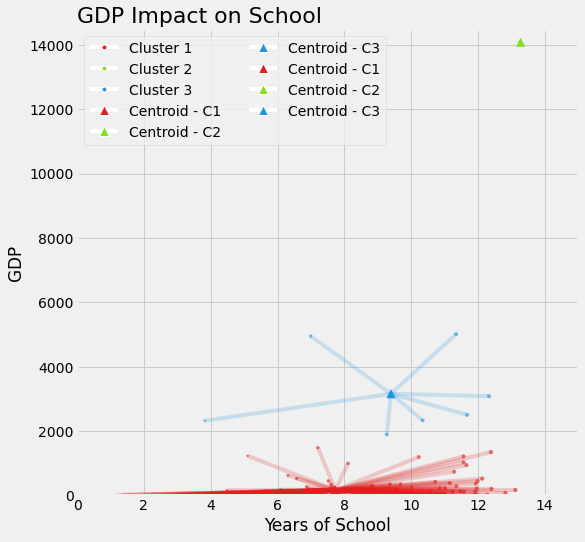

In [31]:
fig, ax = plt.subplots(1, figsize=(8,8))
# plot data
plt.scatter(df.All_25_plus, df.avg_2000_2015, c=df.c, alpha = 0.6, s=df.female_25_plus)
# plot centroids
plt.scatter(cen_x, cen_y, marker='^', c=colors, s=70)
# plot lines
for idx, val in df.iterrows():
    x = [val.All_25_plus, val.cen_x,]
    y = [val.avg_2000_2015, val.cen_y]
    plt.plot(x, y, c=val.c, alpha=0.2)
    
# legend
legend_elements = [Line2D([0], [0], marker='o', color='w',
label='Cluster {}'.format(i+1), 
                   markerfacecolor=mcolor, markersize=5) for i, 
mcolor in enumerate(colors)]
legend_elements.extend([Line2D([0], [0], marker='^', color='w',
label='Centroid - C{}'.format(i+1), 
            markerfacecolor=mcolor, markersize=10) for i, mcolor in 
enumerate(colors)])
legend_elements.extend(cent_leg)
plt.legend(handles=legend_elements, loc='upper left', ncol=2)
# x and y limits
plt.xlim(0,15)
plt.ylim(0,14500)
# title and labels
plt.title('GDP Impact on School', loc='left', fontsize=22)
plt.xlabel('Years of School')
plt.ylabel('GDP')

In [32]:
df.groupby(['cluster']).mean()

,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cen_x,cen_y
cluster,,,,,,,
0,7.348037,7.733741,19.471926,163.317689,70.800000,7.733741,163.317689
1,13.275000,13.275000,0.445000,14074.337562,136.000000,13.275000,14074.337562
2,9.125000,9.396429,6.435000,3154.151372,65.571429,9.396429,3154.151372


# Supervised Learning and Preliminary Data

In [33]:
###preliminary review of the subset of College University before being merged with modified final
h_ed_df.describe()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
count,59.000000,59.0,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000
mean,353.546610,1.0,229.881017,282.851356,159.900847,369.37678,379.218475,330.740508,396.813559,448.558983,50.004576
std,309.691534,0.0,128.823050,200.200661,73.171126,318.43022,305.787634,242.381348,316.655691,295.852672,10.092858
min,1.000000,1.0,2.500000,3.000000,1.000000,1.00000,1.000000,1.000000,1.000000,4.250000,44.180000
25%,82.000000,1.0,104.625000,103.375000,105.250000,62.75000,118.085000,101.375000,105.250000,181.750000,44.790000
50%,291.500000,1.0,278.000000,213.500000,214.000000,259.50000,247.500000,268.500000,328.000000,483.500000,46.280000
75%,552.000000,1.0,361.000000,522.500000,214.000000,606.75000,683.500000,522.000000,746.250000,756.750000,49.780000
max,971.500000,1.0,361.000000,522.500000,214.000000,998.50000,962.000000,806.000000,956.000000,804.000000,100.000000


In [34]:
h_ed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59 entries, Argentina to Uruguay
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   world_rank            59 non-null     float64
 1   national_rank         59 non-null     float64
 2   quality_of_education  59 non-null     float64
 3   alumni_employment     59 non-null     float64
 4   quality_of_faculty    59 non-null     float64
 5   publications          59 non-null     float64
 6   influence             59 non-null     float64
 7   citations             59 non-null     float64
 8   broad_impact          59 non-null     float64
 9   patents               59 non-null     float64
 10  score                 59 non-null     float64
dtypes: float64(11)
memory usage: 5.5+ KB


In [35]:
h_ed_df.corr()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score
world_rank,1.000000,NaN,0.597069,0.755904,0.627145,0.920100,0.862065,0.858061,0.908768,0.729807,-0.536188
national_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_of_education,0.597069,NaN,1.000000,0.446030,0.845748,0.562158,0.570039,0.548860,0.547861,0.434614,-0.590930
alumni_employment,0.755904,NaN,0.446030,1.000000,0.442705,0.601342,0.549113,0.537933,0.568028,0.561378,-0.539092
quality_of_faculty,0.627145,NaN,0.845748,0.442705,1.000000,0.601272,0.655108,0.646750,0.627308,0.531992,-0.662818
publications,0.920100,NaN,0.562158,0.601342,0.601272,1.000000,0.891539,0.900068,0.953361,0.672824,-0.517084
influence,0.862065,NaN,0.570039,0.549113,0.655108,0.891539,1.000000,0.915437,0.944099,0.696907,-0.526425
citations,0.858061,NaN,0.548860,0.537933,0.646750,0.900068,0.915437,1.000000,0.937196,0.642703,-0.527331
broad_impact,0.908768,NaN,0.547861,0.568028,0.627308,0.953361,0.944099,0.937196,1.000000,0.675042,-0.521284
patents,0.729807,NaN,0.434614,0.561378,0.531992,0.672824,0.696907,0.642703,0.675042,1.000000,-0.564994


In [36]:
modified_df_final.corr()

,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster,cen_x,cen_y
female_25_plus,1.000000,0.990859,-0.903200,0.229570,-0.003290,0.136708,0.183651,0.181454
All_25_plus,0.990859,1.000000,-0.890348,0.238820,-0.009049,0.139903,0.187875,0.185616
All_25_plus_no_edu,-0.903200,-0.890348,1.000000,-0.173797,-0.012262,-0.142200,-0.138020,-0.127228
avg_2000_2015,0.229570,0.238820,-0.173797,1.000000,0.086241,0.606618,0.947528,0.959060
country_id,-0.003290,-0.009049,-0.012262,0.086241,1.000000,-0.004255,0.086849,0.101771
cluster,0.136708,0.139903,-0.142200,0.606618,-0.004255,1.000000,0.744660,0.632513
cen_x,0.183651,0.187875,-0.138020,0.947528,0.086849,0.744660,1.000000,0.987976
cen_y,0.181454,0.185616,-0.127228,0.959060,0.101771,0.632513,0.987976,1.000000


In [37]:
h_ed_df.reset_index(inplace=True)
a_final_frame = pd.merge(h_ed_df,modified_df_final,how="left",on='country')
a_final_frame = a_final_frame.drop(['Country Code', 'Indicator Name', 'Indicator Code'], axis=1)
a_final_frame.describe()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster,cen_x,cen_y
count,59.000000,59.0,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,59.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000,55.000000
mean,353.546610,1.0,229.881017,282.851356,159.900847,369.37678,379.218475,330.740508,396.813559,448.558983,50.004576,9.800000,10.071909,6.323000,949.977995,73.000000,0.236364,8.015875,742.518089
std,309.691534,0.0,128.823050,200.200661,73.171126,318.43022,305.787634,242.381348,316.655691,295.852672,10.092858,2.354011,2.121826,9.078826,2096.345879,42.604121,0.637229,0.891469,2058.118387
min,1.000000,1.0,2.500000,3.000000,1.000000,1.00000,1.000000,1.000000,1.000000,4.250000,44.180000,3.230000,4.925000,0.125000,14.641724,3.000000,0.000000,7.733741,163.317689
25%,82.000000,1.0,104.625000,103.375000,105.250000,62.75000,118.085000,101.375000,105.250000,181.750000,44.790000,8.710000,8.832500,0.870000,148.277520,35.500000,0.000000,7.733741,163.317689
50%,291.500000,1.0,278.000000,213.500000,214.000000,259.50000,247.500000,268.500000,328.000000,483.500000,46.280000,10.455000,10.590000,2.625000,281.926930,63.000000,0.000000,7.733741,163.317689
75%,552.000000,1.0,361.000000,522.500000,214.000000,606.75000,683.500000,522.000000,746.250000,756.750000,49.780000,11.632500,11.665000,8.350000,965.707184,113.500000,0.000000,7.733741,163.317689
max,971.500000,1.0,361.000000,522.500000,214.000000,998.50000,962.000000,806.000000,956.000000,804.000000,100.000000,13.275000,13.275000,44.655000,14074.337562,137.000000,2.000000,13.275000,14074.337562


In [38]:
a_final_frame.corr()

,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,patents,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster,cen_x,cen_y
world_rank,1.000000,NaN,0.597069,0.755904,0.627145,0.920100,0.862065,0.858061,0.908768,0.729807,-0.536188,-0.306991,-0.332706,0.241208,-0.379818,0.085049,-0.375885,-0.334535,-0.300966
national_rank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
quality_of_education,0.597069,NaN,1.000000,0.446030,0.845748,0.562158,0.570039,0.548860,0.547861,0.434614,-0.590930,-0.447566,-0.468350,0.292016,-0.407331,0.020361,-0.450575,-0.439887,-0.405160
alumni_employment,0.755904,NaN,0.446030,1.000000,0.442705,0.601342,0.549113,0.537933,0.568028,0.561378,-0.539092,0.022248,-0.008384,-0.025533,-0.426992,-0.017255,-0.371693,-0.359552,-0.330433
quality_of_faculty,0.627145,NaN,0.845748,0.442705,1.000000,0.601272,0.655108,0.646750,0.627308,0.531992,-0.662818,-0.468006,-0.494358,0.282506,-0.426576,-0.054162,-0.441983,-0.466756,-0.437691
publications,0.920100,NaN,0.562158,0.601342,0.601272,1.000000,0.891539,0.900068,0.953361,0.672824,-0.517084,-0.381037,-0.410776,0.303742,-0.374576,0.109275,-0.358339,-0.327645,-0.296880
influence,0.862065,NaN,0.570039,0.549113,0.655108,0.891539,1.000000,0.915437,0.944099,0.696907,-0.526425,-0.514956,-0.515373,0.448021,-0.349984,0.121026,-0.357938,-0.331609,-0.301493
citations,0.858061,NaN,0.548860,0.537933,0.646750,0.900068,0.915437,1.000000,0.937196,0.642703,-0.527331,-0.516349,-0.530806,0.450237,-0.353134,0.142496,-0.331447,-0.329057,-0.304288
broad_impact,0.908768,NaN,0.547861,0.568028,0.627308,0.953361,0.944099,0.937196,1.000000,0.675042,-0.521284,-0.494114,-0.506573,0.421581,-0.358956,0.141211,-0.345778,-0.327159,-0.299033
patents,0.729807,NaN,0.434614,0.561378,0.531992,0.672824,0.696907,0.642703,0.675042,1.000000,-0.564994,-0.358445,-0.377446,0.182739,-0.402937,-0.052522,-0.408874,-0.384561,-0.350976


In [39]:
### Average NANs in all applicable columns
a_final_frame = a_final_frame.round()
a_final_frame.columns[a_final_frame.isna().any()].tolist()

['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']
a_final_frame[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']] = a_final_frame[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']].fillna(value=a_final_frame[['female_25_plus','All_25_plus','All_25_plus_no_edu','avg_2000_2015']].mean())

a_final_frame.head()

,country,world_rank,national_rank,quality_of_education,alumni_employment,quality_of_faculty,publications,influence,citations,broad_impact,...,score,female_25_plus,All_25_plus,All_25_plus_no_edu,avg_2000_2015,country_id,cluster,cen_x,cen_y,c
0,Argentina,372.0,1.0,159.0,488.0,178.0,272.0,349.0,342.0,346.0,...,46.0,9.0,9.0,1.0,346.0,3.0,0.0,8.0,163.0,#DF2020
1,Australia,92.0,1.0,108.0,140.0,132.0,56.0,103.0,74.0,89.0,...,48.0,12.0,12.0,1.0,940.0,5.0,0.0,8.0,163.0,#DF2020
2,Austria,214.0,1.0,196.0,172.0,100.0,228.0,150.0,156.0,196.0,...,47.0,9.0,10.0,2.0,345.0,6.0,0.0,8.0,163.0,#DF2020
3,Belgium,88.0,1.0,361.0,214.0,214.0,44.0,102.0,64.0,52.0,...,52.0,10.0,11.0,5.0,418.0,10.0,0.0,8.0,163.0,#DF2020
4,Brazil,132.0,1.0,300.0,70.0,214.0,60.0,184.0,125.0,163.0,...,50.0,7.0,7.0,14.0,1483.0,15.0,0.0,8.0,163.0,#DF2020


In [40]:
###Causal Inference  ###Average Treatment Effects  -- Failure

#import statsmodels.api as sm
#import statsmodels.formula.api as smf
#from causalinference import CausalModel  Raises error zero control units.  Control units might need to be 0 or 1 exclusively 
###
# This cell generates an error when using the Causal Model.  Values might need to be 0 or 1 exclusively.
# ATE_array = np.array([a_final_frame.quality_of_education,a_final_frame.alumni_employment])
# ATE_array = ATE_array.T.reshape(59,2)

# m=CausalModel(Y=a_final_frame.avg_2000_2015.values, D=a_final_frame.patents.values, X=ATE_array)
# print(a_final_frame[a_final_frame.score==0].shape)
# a_final_frame.score.values


In [41]:
###IV2SLS on merged subset
'''
Endogenous Variable --  a variable that is determined or changed by the relationships it has with other variables.  Correlates with other variables mainly the dependant variable
Exogenous Variable -- independant variable.  Does not dierctly corelate or have a direct effect
instrument variable -- has no direct correlation between the above and dependant variable.
#a_final_frame['citations']  a_final_frame['broad_impact']) --- Test Data
'''



m = IV2SLS(dependent = a_final_frame['female_25_plus'],
           exog=a_final_frame['avg_2000_2015'],
           endog=a_final_frame['score'],
           instruments=a_final_frame['patents'])

iv2sls_1=m.fit(cov_type='robust')

print(iv2sls_1)  ###GDP is significant but number of variables/features and data points is low and show bias.

                          IV-2SLS Estimation Summary                          
Dep. Variable:         female_25_plus   R-squared:                      0.9530
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9514
No. Observations:                  59   F-statistic:                    820.14
Date:                Sun, Jan 30 2022   P-value (F-stat)                0.0000
Time:                        23:03:31   Distribution:                  chi2(2)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
avg_2000_2015    -0.0007     0.0002    -4.3083     0.0000     -0.0010     -0.0004
score             0.2073     0.0088     

In [42]:
###IV2SLS comparison done with modified_df_final.  There are no other inputs as the other features might introduce more bias or noise
mFull = IV2SLS(dependent = modified_df_final['female_25_plus'],
           exog=modified_df_final['avg_2000_2015'],
           endog=None,
           instruments=None)

iv2sls_2=mFull.fit(cov_type='robust')

print(iv2sls_2)  ###GDP is more significant

                            OLS Estimation Summary                            
Dep. Variable:         female_25_plus   R-squared:                      0.1223
Estimator:                        OLS   Adj. R-squared:                 0.1161
No. Observations:                 143   F-statistic:                    7.4551
Date:                Sun, Jan 30 2022   P-value (F-stat)                0.0063
Time:                        23:03:31   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                               Parameter Estimates                               
               Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
---------------------------------------------------------------------------------
avg_2000_2015     0.0020     0.0007     2.7304     0.0063      0.0006      0.0034


In [43]:
### SLS prediction is female dependant on average GDP
SLSresults = iv2sls_1.predict()
country_final = a_final_frame[['country','avg_2000_2015']]

SLSframe = [SLSresults, country_final]
15
pred_frame = pd.concat(SLSframe,axis=1,join='outer')


SLSresultsFull = iv2sls_2.predict()
country_final_Full = modified_df_final[['country','avg_2000_2015']]

SLSframe_Full = [SLSresultsFull, country_final_Full]

pred_frame_Full = pd.concat(SLSframe_Full,axis=1,join='outer')

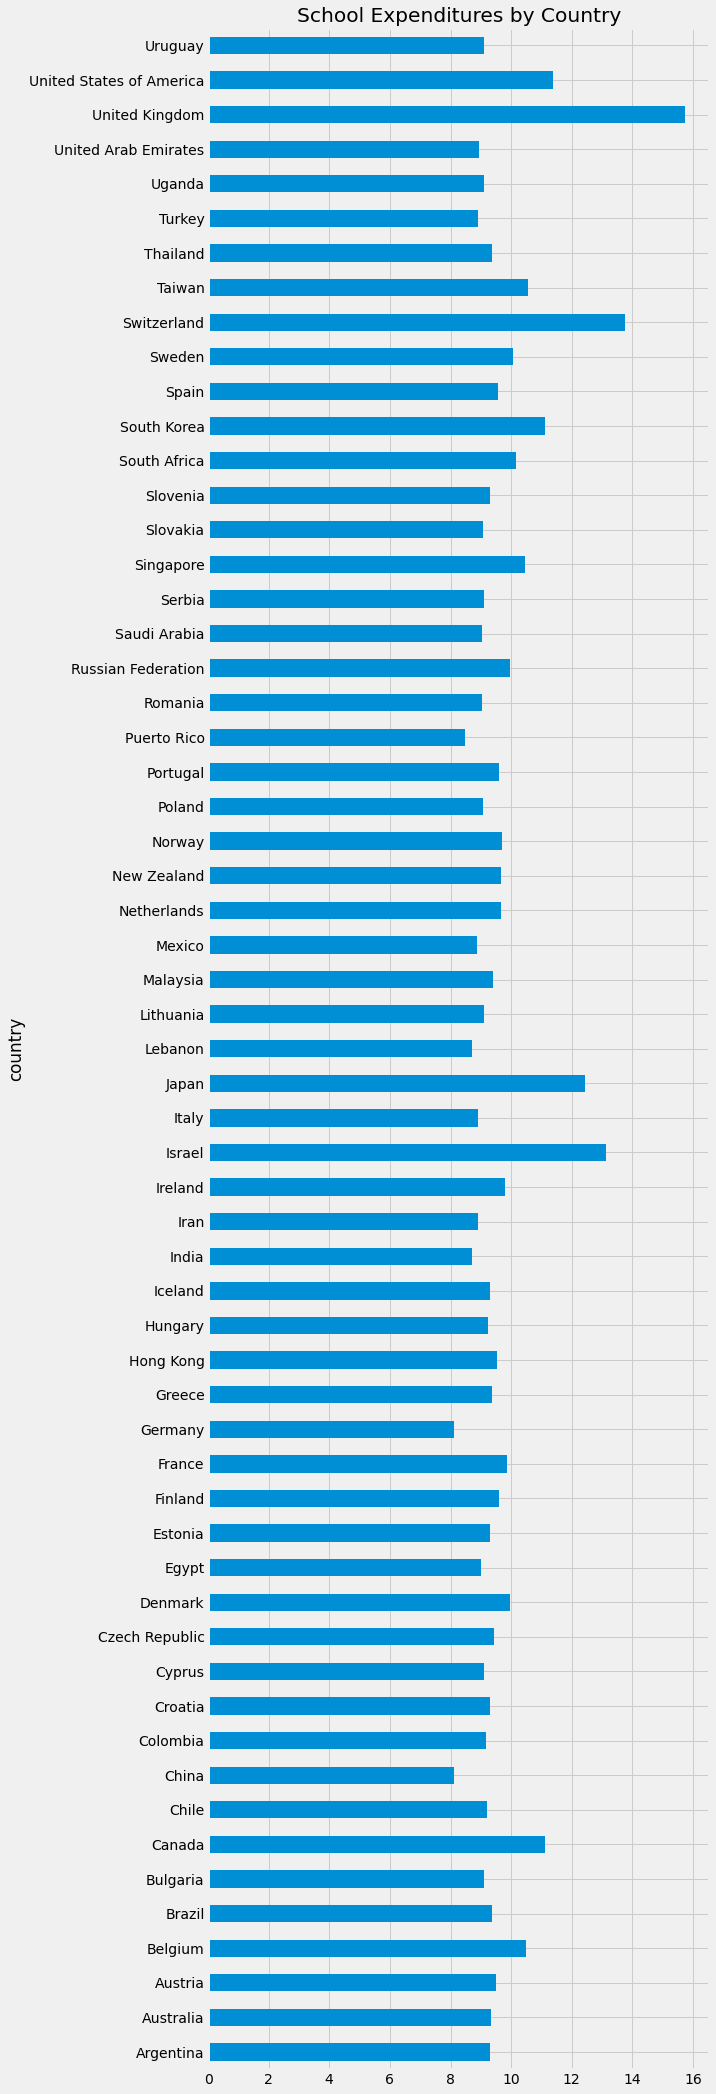

In [44]:
### Outcome of data.  Wester countries are expected to be at the top but the data is skewed.
pred_frame_Full = pred_frame_Full.sort_values(['fitted_values'],ascending = (False))
ax1 = pred_frame.plot.barh(x='country', y='fitted_values', figsize = (8,35), title = "School Expenditures by Country", legend = False)

In [45]:
###Gaussian NB for comparison and testing
country_list = a_final_frame['country'].to_list()
le = LabelEncoder()
country_transformed = le.fit_transform(country_list)

country_transformed

label = a_final_frame['score'].to_list()
#label_array = a_final_frame['score'].as_matrix().reshape(1,len(a_final_frame['score']))
label_droped = a_final_frame.drop(['score','country','cluster','national_rank'], axis=1)

avg_list = a_final_frame['avg_2000_2015'].to_list()
world_list = a_final_frame['female_25_plus'].to_list()

#features = zip[avg_list,world_list]
features = list(map(list, zip(avg_list, world_list)))


X_train, X_test, y_train, y_test = train_test_split(features, label,test_size=0.50, random_state=42)

Gaus = GaussianNB()
Gaus.fit(X_train,y_train)

y_pred = Gaus.predict(X_test)

y_pred

array([47., 45., 48., 45., 48., 46., 49., 48., 49., 45., 48., 45., 45.,
       47., 49., 49., 48., 46., 46., 45., 45., 48., 45., 45., 48., 47.,
       49., 48., 45., 47.])

In [46]:
#Multiple linear regression between GDP, word_rank, broad_impact
a_final_frame.head()

X = a_final_frame[['female_25_plus','quality_of_education']].to_numpy()
y= a_final_frame['avg_2000_2015'].to_numpy()

model = LinearRegression().fit(X, y)

frame_score = model.score(X,y)
y_pred = model.predict(X)
#print(y_pred)

final_score = r2_score(y,y_pred)
mean_sqrd_error = mean_squared_error(y,y_pred)
root_mean_sqrd_error = np.sqrt(mean_squared_error(y,y_pred))

print("R2_Score",final_score)
print("Mean_Squared_Error: ",mean_sqrd_error)
print("Root_Mean_Squared_Error: ",root_mean_sqrd_error)

###Even though the R2 Score is low we still have a high MSE and RMSE due to bias

R2_Score 0.1595145176944226
Mean_Squared_Error:  3380446.3994931486
Root_Mean_Squared_Error:  1838.5990317339854


R2_Score:  0.3228102486210609
Mean_squared_error:  1274982.5354354023
Root_mean_squared_error:  1129.15124559795
Mean_absolute_error:  538.688875646782


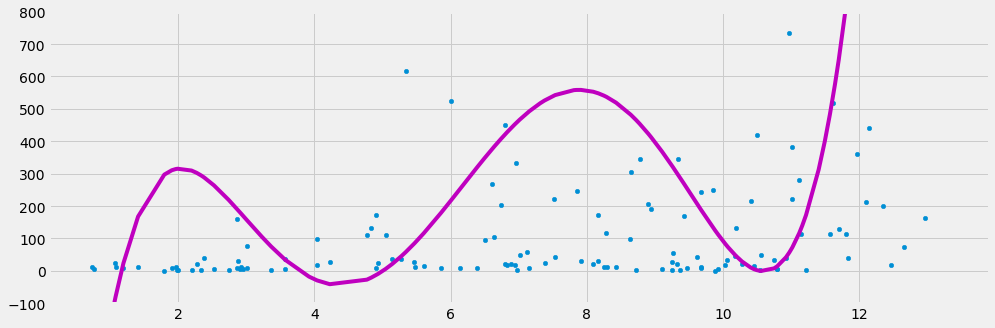

In [47]:
##Polynomial Linear Regression
#using no weights or bias this this possibly fails.  


Xpoly = modified_df_final ['female_25_plus'].to_numpy()
Xpoly = Xpoly.reshape((-1,1))

ypoly = modified_df_final ['avg_2000_2015'].to_numpy()

X_ = PolynomialFeatures(degree=5,include_bias=False).fit_transform(Xpoly)
poly_model = LinearRegression().fit(X_,ypoly)

y_pred1 = poly_model.predict(X_)
#print(y_pred)

final_score1 = r2_score(ypoly,y_pred1)
mean_sqrd_error1 = mean_squared_error(ypoly,y_pred1)
root_mean_sqrd_error1 = np.sqrt(mean_squared_error(ypoly,y_pred1))
mae = mean_absolute_error(ypoly,y_pred1)

print("R2_Score: ",final_score1)
print("Mean_squared_error: ",mean_sqrd_error1)
print("Root_mean_squared_error: ",root_mean_sqrd_error1)
print("Mean_absolute_error: ",mae)

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)
plt.ylim(-100, 800) 
plt.scatter(Xpoly, ypoly, s=20)
# sort the values of x before line plot
sort_axis = operator.itemgetter(0)
sorted_zip = sorted(zip(Xpoly,y_pred1), key=sort_axis)
x, y_pred1 = zip(*sorted_zip)
plt.plot(x, y_pred1, color='m')
plt.show()

#

In [48]:
###LASSO REGRESSION

higherED_df = higherED_df.fillna(0)

dummy = pd.get_dummies(higherED_df[['institution','country']])

y = higherED_df['score']

X_dropped = higherED_df.drop(['score','institution','country'], axis=1).astype('float64')
dropped_list = X_dropped.columns

dropped_list

dummy.head()
X = pd.concat([X_dropped, dummy[['country_United Kingdom','country_United States of America']]],axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

scaler = StandardScaler().fit(X_train[dropped_list]) 

X_train[dropped_list] = scaler.transform(X_train[dropped_list])

X_test[dropped_list] = scaler.transform(X_test[dropped_list])

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

(0.005821722491960459,
 858.8523425678187,
 -4.430576525113921,
 8.409897626446108)

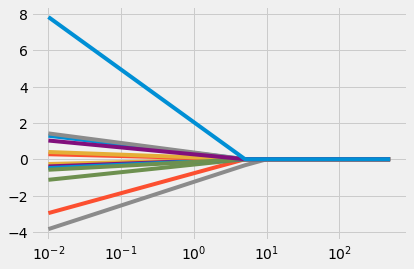

In [49]:
alphas = np.linspace(0.01,500,100)

lasso = Lasso(max_iter=10000)
coefs = []


for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.axis('tight')

In [50]:


# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)
model.alpha_

lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

print(list(zip(lasso_best.coef_, X)))
mean_squared_error(y_test, lasso_best.predict(X_test))

[(1.3835980219860275, 'world_rank'), (-3.019536178929906, 'national_rank'), (-0.2694202738893198, 'quality_of_education'), (-1.1450661575103949, 'alumni_employment'), (-3.841816638571859, 'quality_of_faculty'), (-0.48188123886721584, 'publications'), (-0.554265924820888, 'influence'), (0.310293222791675, 'citations'), (0.46974781028747553, 'broad_impact'), (-0.5894618335484249, 'patents'), (1.4300822097687707, 'year'), (1.1419395017367564, 'country_United Kingdom'), (7.9798831334807, 'country_United States of America')]


26.089078515663918

(2.0, 70.0)

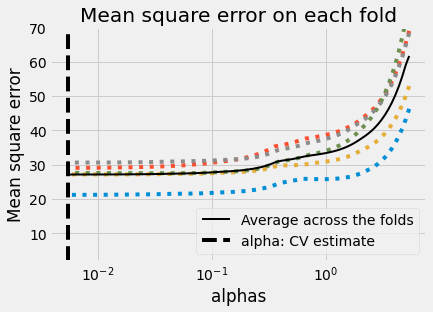

In [51]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 2, 70
plt.ylim(ymin, ymax)

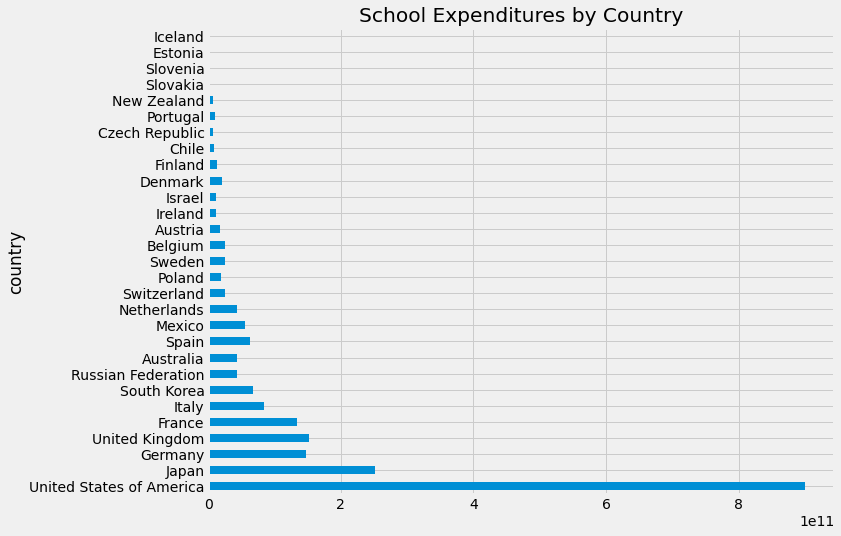

In [52]:

ax = df_all_edu_1.plot.barh(x='country', y='school_expenditures', figsize = (10,8), title = "School Expenditures by Country", legend = False)